# Setting up the Notebook

In [2]:
# Imports

import numpy as np
import argparse
import os
import csv
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation
import albumentations as A
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from PIL import Image
import sys
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from typing import TYPE_CHECKING, Any, Dict, Iterable, List, Optional, Set, Tuple, Union


# Loading in Scott's Model

In [3]:
# The model

# for classes
id2label = {
    0: "unlabeled",
    1: "background",
    2: "disc",
    3: "cup"
}


def color_palette():
    """Color palette that maps each class to RGB values.
    
    This one is actually taken from ADE20k.
    """
    return [[255,0,0], [0,255,0], [0,0,255]]

# for vis
palette = color_palette()


# BEGIN TEST

device = 'cuda:0'
# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                            id2label=id2label,
                                                            ignore_mismatched_sizes=True).to(device)
print(model)

# Specify the path to the state dictionary
model_filename = '/sddata/projects/glaucoma_segmentation_scott/best_maskformer_weights/best_model.pt'
# Load the state dictionary
state_dict = torch.load(model_filename)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MaskFormerForInstanceSegmentation(
  (model): MaskFormerModel(
    (pixel_level_module): MaskFormerPixelLevelModule(
      (encoder): MaskFormerSwinBackbone(
        (model): MaskFormerSwinModel(
          (embeddings): MaskFormerSwinEmbeddings(
            (patch_embeddings): MaskFormerSwinPatchEmbeddings(
              (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): MaskFormerSwinEncoder(
            (layers): ModuleList(
              (0): MaskFormerSwinStage(
                (blocks): ModuleList(
                  (0-1): 2 x MaskFormerSwinLayer(
                    (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                    (attention): MaskFormerSwinAttention(
                      (self): MaskFormerSwinSelfAttention(
                        (query): Linear(in_

<All keys matched successfully>

# Loading in the Testing Data

In [4]:
# Dataset

def convert_to_single_channel(image_path):
    # Open the image
    image = Image.open(image_path)

    # Convert to RGB mode if not already in that mode
    image = image.convert('RGB')

    # Convert the image to a NumPy array
    img_array = np.array(image)

    # Compute the max value along the channel axis
    max_channel = np.argmax(img_array, axis=2) + 1  # Adding 1 to make red 1, green 2, blue 3

    # Define the color mappings after max channel computation
    color_map = {
        1: 1,  # Red
        2: 2,  # Green
        3: 3,  # Blue
    }

    # Create masks based on the max channel values
    masks = np.zeros((img_array.shape[0], img_array.shape[1], len(color_map)), dtype=np.uint8)
    for index, label in color_map.items():
        masks[:, :, index - 1] = max_channel == label

    # Create the single-channel image using the masks
    single_channel_image = np.argmax(masks, axis=2) + 1  # Adding 1 to adjust labels

    return single_channel_image

def convert_grayscale_disc_image(image_path):
    # Open the image
    image = Image.open(image_path)

    # Convert to grayscale mode if not already in that mode
    image = image.convert('L')

    # Convert the image to a NumPy array
    img_array = np.array(image, dtype=np.uint8)

    # Replace black pixels with 1 (background) and white pixels with 2 (disc)
    img_array[img_array >= 1] = 2  # Assuming white pixels have intensity 255
    img_array[img_array == 0] = 1  # Assuming black pixels have intensity 0

    return img_array

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]
    
    return batch


class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, images, masks, transform, data_root_dir, convert_disc=False):
        """
        Args:
            dataset
        """
        self.images = images
        self.masks = masks
        self.transform = transform
        self.data_root_dir = data_root_dir
        self.convert_disc = convert_disc
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        path_to_img = self.data_root_dir + 'images/' + self.images[idx]
        path_to_mask = self.data_root_dir + 'labels/' + self.masks[idx]
        if self.data_root_dir == '/projects/skinder@xsede.org/seg_paper/test_datasets/rimone/':
            path_to_img = self.images[idx].split('/')[-1]
            path_to_img = self.data_root_dir + path_to_img
            path_to_mask = self.masks[idx].split('/')[-1]
            path_to_mask = self.data_root_dir + path_to_mask
             
        original_image = np.array(Image.open(path_to_img))
        original_segmentation_map = None
        if self.convert_disc:
            original_segmentation_map = convert_grayscale_disc_image(path_to_mask)
        else:
            original_segmentation_map = convert_to_single_channel(path_to_mask)
        
        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

train_ratio = 0.8
# transforms
ADE_MEAN = np.array([0.709, 0.439, 0.287])
ADE_STD = np.array([0.210, 0.220, 0.199])

train_transform = A.Compose([
    # A.ColorJitter(brightness=jitters[0], contrast=jitters[1], saturation=jitters[2], hue=jitters[3], p=jitters[4]), # Not necessary, so we are removing it
    A.Resize(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])
test_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD)
])

csv_file_path = '/sddata/data/retina_datasets_preprocessed/seg_paper_public/all_tightly_cropped_vtwo.csv'  # Replace with the actual path
data_df = pd.read_csv(csv_file_path)
image_paths = data_df['image'].tolist()  # Replace with the actual column name
mask_paths = data_df['label'].tolist()  # Replace with the actual column name

# Split dataset into train and temp sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=1 - train_ratio, random_state=42)
cal_image_paths, test_image_paths, cal_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, test_size=0.2, random_state=42)

train_dataset = ImageSegmentationDataset(train_image_paths, train_mask_paths, transform=train_transform, data_root_dir='/sddata/data/retina_datasets_preprocessed/seg_paper_public/')
cal_dataset = ImageSegmentationDataset(cal_image_paths, cal_mask_paths, transform=test_transform, data_root_dir='/sddata/data/retina_datasets_preprocessed/seg_paper_public/')
test_dataset = ImageSegmentationDataset(test_image_paths, test_mask_paths, transform=test_transform, data_root_dir='/sddata/data/retina_datasets_preprocessed/seg_paper_public/')

# Create a preprocessor
preprocessor = MaskFormerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False) # Not in use

# Data loaders
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
cal_dataloader = DataLoader(cal_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(len(train_dataset), len(cal_dataset), len(test_dataset))

1533 307 77


/usr/local/lib/python3.8/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:429: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


# Functions

In [5]:
# Post-Segmentation Function

def post_process_semantic_segmentation_custom(outputs, target_sizes: Optional[List[Tuple[int, int]]] = None
    ) -> "torch.Tensor":
        """
        Converts the output of [`MaskFormerForInstanceSegmentation`] into semantic segmentation maps. Only supports
        PyTorch.

        Args:
            outputs ([`MaskFormerForInstanceSegmentation`]):
                Raw outputs of the model.
            target_sizes (`List[Tuple[int, int]]`, *optional*):
                List of length (batch_size), where each list item (`Tuple[int, int]]`) corresponds to the requested
                final size (height, width) of each prediction. If left to None, predictions will not be resized.
        Returns:
            `List[torch.Tensor]`:
                A list of length `batch_size`, where each item is a semantic segmentation map of shape (height, width)
                corresponding to the target_sizes entry (if `target_sizes` is specified). Each entry of each
                `torch.Tensor` correspond to a semantic class id.
        """
        class_queries_logits = outputs.class_queries_logits  # [batch_size, num_queries, num_classes+1]
        masks_queries_logits = outputs.masks_queries_logits  # [batch_size, num_queries, height, width]

        # Remove the null class `[..., :-1]`
        masks_classes = class_queries_logits.softmax(dim=-1)[..., :-1]
        masks_probs = masks_queries_logits.sigmoid()  # [batch_size, num_queries, height, width]

        # Semantic segmentation logits of shape (batch_size, num_classes, height, width)
        segmentation = torch.einsum("bqc, bqhw -> bchw", masks_classes, masks_probs)
        batch_size = class_queries_logits.shape[0]

        # Resize logits and compute semantic segmentation maps
        if target_sizes is not None:
            if batch_size != len(target_sizes):
                raise ValueError(
                    "Make sure that you pass in as many target sizes as the batch dimension of the logits"
                )

            semantic_segmentation = []
            semantic_segmentation_probs = []
            for idx in range(batch_size):
                resized_logits = torch.nn.functional.interpolate(
                    segmentation[idx].unsqueeze(dim=0), size=target_sizes[idx], mode="bilinear", align_corners=False
                )
                semantic_map_probs = resized_logits[0]
                semantic_map = resized_logits[0].argmax(dim=0)
                semantic_segmentation.append(semantic_map)
                semantic_segmentation_probs.append(semantic_map_probs)
        else:
            semantic_segmentation = segmentation.argmax(dim=1)
            semantic_segmentation = [semantic_segmentation[i] for i in range(semantic_segmentation.shape[0])]
            semantic_segmentation_probs = segmentation
            semantic_segmentation = [semantic_segmentation_probs[i] for i in range(semantic_segmentation.shape[0])]

        return semantic_segmentation, semantic_segmentation_probs

In [6]:
# Creating Label and Probability Sets

def create_labels_probs(dataloader, model, device, stopping):

    labels_list = []
    probs_list = []

    when_to_stop = stopping
    current_batch = 0
    with torch.no_grad():
        for batch in dataloader:
            model.to(device)
            model.eval()
            current_batch += 1
            if current_batch == when_to_stop:
                break
            images = batch['pixel_values'].to(device)
            labels = batch['mask_labels']
            output = model(images)
            model.to('cpu')
            target_sizes = [(512, 512) for _ in range(len(images))]

            # predict segmentation maps
            pred_labels, pred_softmax = post_process_semantic_segmentation_custom(output, target_sizes=target_sizes)

            labels_list.extend(labels)
            probs_list.extend(pred_softmax)

    return labels_list, probs_list

In [7]:
# Conformal Uncertainty Quantification Functions

## Calibration Scores
def get_calibration_scores_lac(y_cal, cal_probs):

    # Flatten the model output and ground truth labels
    flat_model_output = cal_probs.view(cal_probs.size(0), cal_probs.size(1), -1)
    flat_ground_truth_labels = y_cal.view(y_cal.size(0), -1)

    # Use ground truth labels as indices to extract predicted probabilities
    predicted_probabilities = flat_model_output.gather(1, flat_ground_truth_labels.unsqueeze(1))

    # Reshape predicted_probabilities to (batch_size, 1, height, width)
    cal_scores = 1 - predicted_probabilities.view(y_cal.size())

    '''
    11/29: Not sure why we need cal_scores".squeeze(1).squeeze(1)". Look into this!
    '''

    return cal_scores.squeeze(1).squeeze(1)

def get_calibration_scores_topk(y_cal, y_cal_prob):

    # Needed because of [:,::-1,:,:] on PyTorch tensors
    y_cal = np.squeeze(np.array(y_cal))
    y_cal_prob = np.array(y_cal_prob)
    h = y_cal_prob.shape[2]
    w = y_cal_prob.shape[3]

    # Setup
    n_cal=y_cal_prob.shape[0] # number of calibration points

    # Calibration Scores
    cal_scores_blank = np.zeros((n_cal, h, w))
    cal_pi = y_cal_prob.argsort(1)
    cal_pi = cal_pi[:,::-1,:,:]

    for i in range(cal_scores_blank.shape[1]):
        for j in range(cal_scores_blank.shape[2]):
            cal_L_ij = np.where(cal_pi[:,:,i,j] == y_cal[:,i,j][:,None])[1]
            cal_scores = cal_L_ij
            cal_scores_blank[:,i,j] = torch.Tensor(cal_scores)

    return np.expand_dims(cal_scores_blank, axis=1), cal_pi

def get_calibration_scores_aps(y_cal, y_cal_prob):

    # Needed because of [:,::-1,:,:] on PyTorch tensors
    y_cal = np.squeeze(np.array(y_cal))
    y_cal_prob = np.array(y_cal_prob)
    h = y_cal_prob.shape[2]
    w = y_cal_prob.shape[3]

    # Setup
    n_cal=y_cal_prob.shape[0] # number of calibration points

    # Calibration Scores
    cal_scores_blank = np.zeros((n_cal, h, w))
    cal_pi = y_cal_prob.argsort(1)[:,::-1,:,:]
    cal_srt = np.take_along_axis(y_cal_prob,cal_pi,axis=1).cumsum(axis=1)
    # cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[range(n), y_cal]
    # print(cal_scores.shape)
    for i in range(cal_scores_blank.shape[1]):
        for j in range(cal_scores_blank.shape[2]):
            cal_L_ij = np.where(cal_pi[:,:,i,j] == y_cal[:,i,j][:,None])[1]
            cal_srt_ij = cal_srt[:,:,i,j]
            cal_scores = cal_srt_ij.cumsum(axis=1)[np.arange(n_cal),cal_L_ij]
            cal_scores_blank[:,i,j] = cal_scores

    return np.expand_dims(cal_scores_blank, axis =1)

def get_calibration_scores_raps(y_cal, y_cal_prob, lam_reg, k_reg):

    '''
    Note, k_reg is qhat_topk
    '''

    # Needed because of [:,::-1,:,:] on PyTorch tensors
    k_reg = k_reg.squeeze(0).squeeze(0)
    y_cal = np.squeeze(np.array(y_cal))
    y_cal_prob = np.array(y_cal_prob)
    h = y_cal_prob.shape[2]
    w = y_cal_prob.shape[3]

    # Setup
    n_cal=y_cal_prob.shape[0] # number of calibration points
    n_classes = y_cal_prob.shape[1]

    # Calibration Scores
    cal_scores_blank = np.zeros((n_cal, h, w))
    reg_tensor_blank = np.zeros((n_classes,h,w))

    cal_pi = y_cal_prob.argsort(1)
    cal_pi = cal_pi[:,::-1,:,:]
    cal_srt = np.take_along_axis(y_cal_prob,cal_pi,axis=1)
    for i in range(cal_scores_blank.shape[1]):
        for j in range(cal_scores_blank.shape[2]):
            k_reg_ij = int(k_reg[i,j])
            if k_reg_ij >= n_classes: # If k_reg is more than the classes, we will have an issue!
                k_reg_ij = 0
            reg_vec = np.array(k_reg_ij*[0,] + (n_classes-k_reg_ij)*[lam_reg,])[None, :]
            reg_tensor_blank[:,i,j] = reg_vec[0]
            cal_L_ij = np.where(cal_pi[:,:,i,j] == y_cal[:,i,j][:,None])[1]
            cal_srt_reg_ij = cal_srt[:,:,i,j] + reg_vec
            cal_scores = cal_srt_reg_ij.cumsum(axis=1)[np.arange(n_cal),cal_L_ij]

            cal_scores_blank[:,i,j] = torch.Tensor(cal_scores)

    return np.expand_dims(cal_scores_blank, axis=1), np.expand_dims(reg_tensor_blank, axis = 0)

## Quantiles
def find_quantile_segmentation(cal_scores, alpha):

    print('Cal scores', cal_scores.shape)

    """
    Find the quantile for each pixel in the input image.

    Parameters:
    - cal_scores: Array of calibration scores with shape (batch, 1, height, width).
    - alpha: Desired quantile level.

    Returns:
    - qhat: Quantile for each pixel with shape (height, width) or (1, height, width).
    """
    n_cal = cal_scores.shape[0]

    # Flatten the calibration scores for each pixel
    cal_scores_flat = cal_scores.reshape(cal_scores.shape[0], -1)

    # Calculate the quantile for each pixel
    qhat = np.quantile(cal_scores_flat, np.ceil((n_cal + 1) * (1 - alpha))/n_cal, axis=0, method='linear')
    # Reshape the result to match the input shape
    qhat = qhat.reshape(1, *cal_scores.shape[2:])

    return torch.Tensor(qhat[0])

## Prediction Sets
def cuq_seg_pred_set_lac(cal_scores, alpha, y_test_probs, y_test):

    # Ensure qhat has the same shape as y_test_probs for broadcasting
    qhat = find_quantile_segmentation(cal_scores, alpha).unsqueeze(0).unsqueeze(0)

    # Create prediction sets by thresholding each channel independently
    prediction_sets = y_test_probs >= (1 - qhat)

    # Calculate the average prediction per pixel across images
    average_per_pixel_per_image = torch.mean(prediction_sets.float(), dim=1)

    # Calculate the average prediction per image across pixels
    average_per_image = torch.mean(prediction_sets.float(), dim=(1, 2, 3))

    if y_test != None:
        pct_coverages = np.zeros((y_test.shape[2], y_test.shape[2]))
        for i in range(y_test.shape[2]):
            for j in range(y_test.shape[3]):
                prediction_sets_ij = prediction_sets[:,:,i,j].numpy()
                y_test_ij = y_test[:,0,i,j]
                pct_coverage = prediction_sets_ij[np.arange(y_test.shape[0]), y_test_ij].mean()
                pct_coverages[i,j] = np.round(pct_coverage, 3)
    
    return prediction_sets, average_per_pixel_per_image, average_per_image, pct_coverages

def cuq_seg_pred_set_topk(cal_scores, alpha, test_probs, y_test):

    # Setup
    test_probs = test_probs.numpy() # Needed because of [:,::-1,:,:]

    # Ensure qhat has the same shape as y_test_probs for broadcasting
    qhat = np.ceil(find_quantile_segmentation(cal_scores, alpha).unsqueeze(0).unsqueeze(0)).numpy()

    # Val pi
    val_pi = test_probs.argsort(1)[:,::-1]

    blank_pred_sets = np.zeros_like(val_pi)
    for i in range(val_pi.shape[2]):
        for j in range(val_pi.shape[3]):
            val_pi_ij = val_pi[:,:,i,j]
            qhat_ij = int(qhat[0,0,i,j])
            val_pi_ij_cutoff = val_pi_ij[:,:qhat_ij + 1] # This gives us C_test = {pi_1, ..., pi_qhat} which contains {0,1,2}, but maybe not all (as it is only up to pi_qhat)
            # Create a 2D binary mask
            binary_masks = np.zeros((val_pi_ij_cutoff.shape[0], 3), dtype=bool)
            # Set True for indices present in each sub-array
            binary_masks[np.arange(val_pi_ij_cutoff.shape[0])[:, None], val_pi_ij_cutoff] = True # This transforms the C_test into {T/F, T/F, T/F} based on whether that class shows up in C_test
            blank_pred_sets[:,:,i,j] = binary_masks

    prediction_sets = blank_pred_sets

    # Prediction Sets Stats
    average_per_pixel_per_image = np.mean(prediction_sets, axis=1)
    average_per_image = np.mean(prediction_sets, axis=(1, 2, 3))

    if y_test != None:
        pct_coverages = np.zeros((y_test.shape[2], y_test.shape[2]))
        for i in range(y_test.shape[2]):
            for j in range(y_test.shape[3]):
                prediction_sets_ij = prediction_sets[:,:,i,j]
                y_test_ij = y_test[:,0,i,j]
                pct_coverage = prediction_sets_ij[np.arange(y_test.shape[0]), y_test_ij].mean()
                pct_coverages[i,j] = np.round(pct_coverage, 3)

    return prediction_sets, average_per_pixel_per_image, average_per_image, qhat, pct_coverages

def cuq_seg_pred_set_aps(cal_scores, y_test_probs, alpha, y_test):

    # Setup
    test_probs = y_test_probs.numpy() # Needed because of [:,::-1,:,:]

    # qhat
    qhat = find_quantile_segmentation(cal_scores, alpha).numpy()

    # Val pi
    val_pi = test_probs.argsort(1)[:, ::-1]
    val_srt = np.take_along_axis(test_probs, val_pi, axis=1).cumsum(axis=1)
    indicators = val_srt.cumsum(axis=1) <= qhat
    prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)

    # Prediction Sets Stats
    average_per_pixel_per_image = np.mean(prediction_sets, axis=1)
    average_per_image = np.mean(prediction_sets, axis=(1, 2, 3))

    if y_test != None:
        pct_coverages = np.zeros((y_test.shape[2], y_test.shape[2]))
        for i in range(y_test.shape[2]):
            for j in range(y_test.shape[3]):
                prediction_sets_ij = prediction_sets[:,:,i,j]
                y_test_ij = y_test[:,0,i,j]
                pct_coverage = prediction_sets_ij[np.arange(y_test.shape[0]), y_test_ij].mean()
                pct_coverages[i,j] = np.round(pct_coverage, 3)

    return prediction_sets, average_per_pixel_per_image, average_per_image, pct_coverages, qhat, val_pi

def cuq_seg_pred_set_aps_v2(cal_scores, y_test_probs, alpha, y_test):

    # Setup
    test_probs = y_test_probs.numpy() # Needed because of [:,::-1,:,:]

    # qhat
    qhat = find_quantile_segmentation(cal_scores, alpha).numpy()

    # Val pi
    val_pi = test_probs.argsort(1)[:, ::-1]

    blank_pred_sets = np.zeros_like(val_pi)
    for i in range(val_pi.shape[2]):
        for j in range(val_pi.shape[3]):
            val_pi_ij = val_pi[:,:,i,j]
            qhat_ij = qhat[i,j]
            val_srt_ij = np.take_along_axis(test_probs[:,:,i,j], val_pi_ij, axis=1).cumsum(axis=1)
            indicators_ij = val_srt_ij.cumsum(axis=1) <= qhat_ij
            ps = np.take_along_axis(indicators_ij,val_pi_ij.argsort(axis=1),axis=1)
            blank_pred_sets[:,:,i,j] = ps

    prediction_sets = blank_pred_sets

    # Prediction Sets Stats
    average_per_pixel_per_image = np.mean(prediction_sets, axis=1)
    average_per_image = np.mean(prediction_sets, axis=(1, 2, 3))

    if y_test != None:
        pct_coverages = np.zeros((y_test.shape[2], y_test.shape[2]))
        for i in range(y_test.shape[2]):
            for j in range(y_test.shape[3]):
                prediction_sets_ij = prediction_sets[:,:,i,j]
                y_test_ij = y_test[:,0,i,j]
                pct_coverage = prediction_sets_ij[np.arange(y_test.shape[0]), y_test_ij].mean()
                pct_coverages[i,j] = np.round(pct_coverage, 3)

    return prediction_sets, average_per_pixel_per_image, average_per_image, pct_coverages


def cuq_seg_pred_set_raps(cal_scores, reg_vec_tensor, y_test_probs, disallow_zero_sets, rand, alpha, y_test):

    # Setup
    test_probs = y_test_probs.numpy() # Needed because of [:,::-1,:,:]

    # qhat
    qhat = find_quantile_segmentation(cal_scores, alpha).numpy()

    # Val pi
    n_test = y_test_probs.shape[0]
    val_pi = test_probs.argsort(1)[:,::-1]
    val_srt = np.take_along_axis(test_probs,val_pi,axis=1)
    val_srt_reg = val_srt + reg_vec_tensor
    
    # Indicators
    indicators = (val_srt_reg.cumsum(axis=1) - np.random.rand(n_test,1,1,1)*val_srt_reg) <= qhat if rand else val_srt_reg.cumsum(axis=1) - val_srt_reg <= qhat
    if disallow_zero_sets: 
        indicators[:,0] = True

    # Prediction Sets 
    prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)

    # Prediction Sets Stats
    average_per_pixel_per_image = np.mean(prediction_sets, axis=1)
    average_per_image = np.mean(prediction_sets, axis=(1, 2, 3))

    if y_test != None:
        pct_coverages = np.zeros((y_test.shape[2], y_test.shape[2]))
        for i in range(y_test.shape[2]):
            for j in range(y_test.shape[3]):
                prediction_sets_ij = prediction_sets[:,:,i,j]
                y_test_ij = y_test[:,0,i,j]
                pct_coverage = prediction_sets_ij[np.arange(y_test.shape[0]), y_test_ij].mean()
                pct_coverages[i,j] = np.round(pct_coverage, 3)

    return prediction_sets, average_per_pixel_per_image, average_per_image, pct_coverages


def cuq_seg_pred_set_raps_v2(cal_scores, reg_vec_tensor, y_test_probs, disallow_zero_sets, rand, alpha, y_test):

    # Setup
    test_probs = y_test_probs.numpy() # Needed because of [:,::-1,:,:]

    # qhat
    qhat = find_quantile_segmentation(cal_scores, alpha).numpy()

    # Val pi
    n_test = y_test_probs.shape[0]
    val_pi = test_probs.argsort(1)[:,::-1]

    blank_pred_sets = np.zeros_like(val_pi)
    for i in range(val_pi.shape[2]):
        for j in range(val_pi.shape[3]):
            val_pi_ij = val_pi[:,:,i,j]
            qhat_ij = qhat[i,j]
            val_srt_ij = np.take_along_axis(test_probs[:,:,i,j], val_pi_ij, axis=1)
            val_srt_reg_ij = val_srt_ij + reg_vec_tensor[:,:,i,j]
            indicators_ij = (val_srt_reg_ij.cumsum(axis=1) - np.random.rand(n_test,1)*val_srt_reg_ij) <= qhat_ij if rand else val_srt_reg_ij.cumsum(axis=1) - val_srt_reg_ij <= qhat_ij
            # print(indicators_ij)
            # sys.exit()
            if disallow_zero_sets: 
                indicators_ij[:,0] = True

            # Prediction Sets 
            ps = np.take_along_axis(indicators_ij,val_pi_ij.argsort(axis=1),axis=1)
            blank_pred_sets[:,:,i,j] = ps

    prediction_sets = blank_pred_sets
    
    # Prediction Sets Stats
    average_per_pixel_per_image = np.mean(prediction_sets, axis=1)
    average_per_image = np.mean(prediction_sets, axis=(1, 2, 3))

    if y_test != None:
        pct_coverages = np.zeros((y_test.shape[2], y_test.shape[2]))
        for i in range(y_test.shape[2]):
            for j in range(y_test.shape[3]):
                prediction_sets_ij = prediction_sets[:,:,i,j]
                y_test_ij = y_test[:,0,i,j]
                pct_coverage = prediction_sets_ij[np.arange(y_test.shape[0]), y_test_ij].mean()
                pct_coverages[i,j] = np.round(pct_coverage, 3)

    return prediction_sets, average_per_pixel_per_image, average_per_image, pct_coverages

In [8]:
# Plotting Functions

# Plotting/Exploring Functions

def plot_classes(prediction_set, title):

    '''
    This function expects a single prediction image of shape (3, H, W)
    '''

    # Convert all pixels at once
    pixel_values = np.packbits(prediction_set, axis=0)
    # Print the mapping
    for i in range(2**3):  # Assuming 3 boolean values (bits)
        binary_representation = format(i, '03b')  # Convert integer to binary with leading zeros
        boolean_array = np.array(list(map(int, binary_representation)), dtype=bool)
        pixel_value = np.packbits(boolean_array)
        print(f"Boolean Array: {boolean_array}, Pixel Value: {pixel_value[0]}")

    # Print the result
    plt.imshow(pixel_values.transpose(1,2,0))
    plt.title(title)
    plt.colorbar()
    plt.show()

def plot_specific_class(prediction_set, target_boolean_array):

    '''
    This function expects a single prediction image of shape (3, H, W)
    The target boolean list must be np.array([Bool, Bool, Bool]) or just just a list [Bool, Bool, Bool]
    '''
    # Numpy boolean list
    boolean_array = np.array(target_boolean_array)

    try:
        # Create a mask for the target boolean array
        target_mask = np.all(prediction_set.numpy() == target_boolean_array[:, None, None], axis=0)
    except:
        # Create a mask for the target boolean array
        target_mask = np.all(prediction_set == target_boolean_array[:, None, None], axis=0)

    
    # Plot only the pixels with the target boolean array
    plt.imshow(target_mask, cmap='gray')  # Assuming binary values, adjust colormap if needed
    plt.title(f"Pixels with Boolean Array {boolean_array}")
    plt.show()

def plot_multiple_alg_classes(prediction_sets, titles, plot_title):

    '''
    This function expects a single prediction image of shape (3, H, W)
    '''

    # Convert all pixels at once
    pixel_values = [np.packbits(prediction_set, axis=0) for prediction_set in prediction_sets]

    # Print the mapping
    for i in range(2**3):  # Assuming 3 boolean values (bits)
        binary_representation = format(i, '03b')  # Convert integer to binary with leading zeros
        boolean_array = np.array(list(map(int, binary_representation)), dtype=bool)
        pixel_value = np.packbits(boolean_array)
        print(f"Boolean Array: {boolean_array}, Pixel Value: {pixel_value[0]}")

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    # Plot each image with its title
    for i in range(4):
        row, col = divmod(i, 2)
        im = axs[row, col].imshow(pixel_values[i].transpose(1,2,0))  # Assuming grayscale images
        axs[row, col].set_title(titles[i])
        axs[row, col].axis('off')  # Turn off axis

        # Add a color bar for each image
        cbar = fig.colorbar(im, ax=axs[row, col], orientation='vertical', fraction=0.05, pad=0.05)

    # Add a common title for the entire figure
    fig.suptitle(plot_title, fontsize=16)

    plt.show()

def plot_multiple_pct_coverages(pct_coverages, titles, plot_title):

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    # Plot each image with its title
    for i in range(4):
        row, col = divmod(i, 2)
        im = axs[row, col].imshow(pct_coverages[i])
        axs[row, col].set_title(titles[i])
        axs[row, col].axis('off')  # Turn off axis

        # Add a color bar for each image
        cbar = fig.colorbar(im, ax=axs[row, col], orientation='vertical', fraction=0.05, pad=0.05)

    # Add a common title for the entire figure
    fig.suptitle(plot_title, fontsize=16)

    plt.show()

# Creating and Organizing Our Needed Sets

In [9]:
# Probs and Labels

# Creation
y_cal, cal_probs = create_labels_probs(cal_dataloader, model, device, 50)
y_test, test_probs = create_labels_probs(test_dataloader, model, device, 50)

In [10]:

# Stacking and Argmaxing
y_cal_st = torch.stack(y_cal, dim=0)
y_cal_prep = torch.argmax(y_cal_st, dim=1)
y_test_st = torch.stack(y_test, dim=0)
y_test_prep = torch.argmax(y_test_st, dim=1)
cal_probs_st = torch.stack(cal_probs, dim=0)
test_probs_st = torch.stack(test_probs, dim=0)

In [11]:
cal_probs = cal_probs_st.detach()[:,1:,:,:].cpu()
test_probs = test_probs_st.detach()[:,1:,:,:].cpu()
y_cal = y_cal_prep.detach().unsqueeze(1).cpu()
y_test = y_test_prep.detach().unsqueeze(1).cpu()

print(cal_probs.shape, test_probs.shape, y_cal.shape, y_test.shape)

torch.Size([307, 3, 512, 512]) torch.Size([77, 3, 512, 512]) torch.Size([307, 1, 512, 512]) torch.Size([77, 1, 512, 512])


# Conformal Prediction

### LAC

Cal scores torch.Size([307, 1, 512, 512])
pred set shape: torch.Size([77, 3, 512, 512]), average per pixel per image: torch.Size([77, 512, 512]), average per image: torch.Size([77])
percent coverage across all pixels 0.887
Mean prediction set size across all pixels and test images: 0.34599998593330383


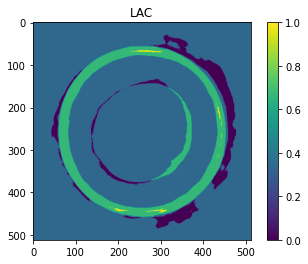

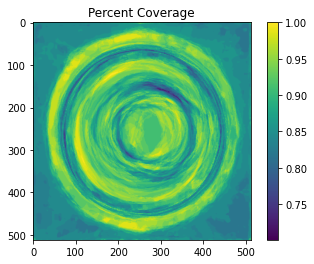

In [11]:
# Prediction sets

cal_scores_lac = get_calibration_scores_lac(y_cal, cal_probs)
prediction_sets_lac, average_per_pixel_per_image_lac, average_per_image_lac, pct_coverages_lac = cuq_seg_pred_set_lac(cal_scores_lac.unsqueeze(1), 0.1, test_probs, y_test)

print(f'pred set shape: {prediction_sets_lac.shape}, average per pixel per image: {average_per_pixel_per_image_lac.shape}, average per image: {average_per_image_lac.shape}')
print(f'percent coverage across all pixels {np.round(pct_coverages_lac.mean(), 3)}')
print(f'Mean prediction set size across all pixels and test images: {np.round(average_per_image_lac.mean(), 3)}')

plt.imshow(average_per_pixel_per_image_lac[0])
plt.title('LAC')
plt.colorbar()
plt.show()

plt.imshow(100*pct_coverages_lac)
plt.title('Percent Coverage')
plt.colorbar()
plt.show()

Boolean Array: [False False False], Pixel Value: 0
Boolean Array: [False False  True], Pixel Value: 32
Boolean Array: [False  True False], Pixel Value: 64
Boolean Array: [False  True  True], Pixel Value: 96
Boolean Array: [ True False False], Pixel Value: 128
Boolean Array: [ True False  True], Pixel Value: 160
Boolean Array: [ True  True False], Pixel Value: 192
Boolean Array: [ True  True  True], Pixel Value: 224


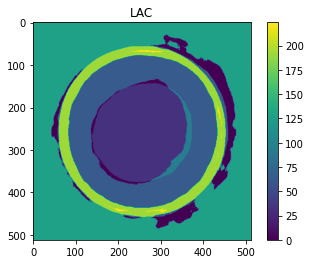

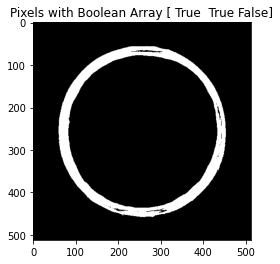

In [12]:
# Plotting

plot_classes(prediction_sets_lac[0], 'LAC')

plot_specific_class(prediction_sets_lac[0], np.array([True, True, False]))

### Top-K

Cal scores (307, 1, 512, 512)
Pred set shape: (77, 3, 512, 512), Average per pixel per image: (77, 512, 512), Average per image: (77,)
Percent coverage across all pixels 0.989
Mean prediction set size across all pixels and test images: 0.432


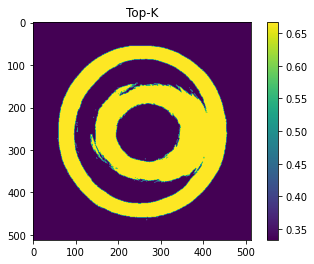

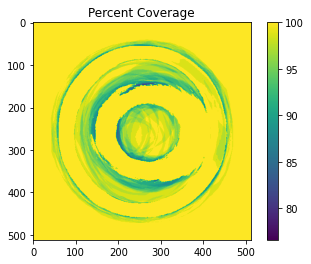

In [14]:
# Prediction sets

cal_scores_topk, cal_pi_topk = get_calibration_scores_topk(y_cal, cal_probs)
prediction_sets_topk, average_per_pixel_per_image_topk, average_per_image_topk, qhat_topk, pct_coverages_topk = cuq_seg_pred_set_topk(cal_scores_topk, 0.1, test_probs, y_test)

print(f'Pred set shape: {prediction_sets_topk.shape}, Average per pixel per image: {average_per_pixel_per_image_topk.shape}, Average per image: {average_per_image_topk.shape}')
print(f'Percent coverage across all pixels {np.round(pct_coverages_topk.mean(), 3)}')
print(f'Mean prediction set size across all pixels and test images: {np.round(average_per_image_topk.mean(), 3)}')

plt.imshow(average_per_pixel_per_image_topk[0])
plt.title('Top-K')
plt.colorbar()
plt.show()

plt.imshow(100*pct_coverages_topk)
plt.title('Percent Coverage')
plt.colorbar()
plt.show()


Boolean Array: [False False False], Pixel Value: 0
Boolean Array: [False False  True], Pixel Value: 32
Boolean Array: [False  True False], Pixel Value: 64
Boolean Array: [False  True  True], Pixel Value: 96
Boolean Array: [ True False False], Pixel Value: 128
Boolean Array: [ True False  True], Pixel Value: 160
Boolean Array: [ True  True False], Pixel Value: 192
Boolean Array: [ True  True  True], Pixel Value: 224


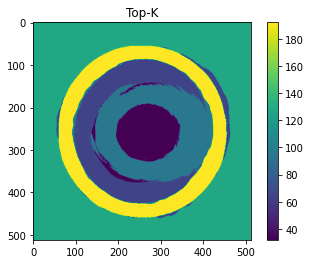

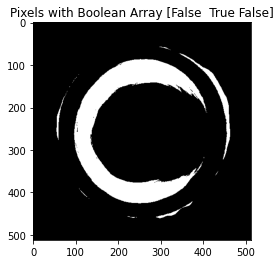

In [15]:
# Plotting

plot_classes(prediction_sets_topk[0], 'Top-K')

plot_specific_class(prediction_sets_topk[0], np.array([False, True, False]))

### APS

Cal scores (307, 1, 512, 512)
pred set shape: (77, 3, 512, 512), average per pixel per image: (77, 512, 512), average per image: (77,)
Percent coverage across all pixels 0.904
Mean prediction set size across all pixels and test images: 0.349


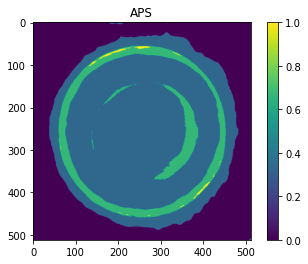

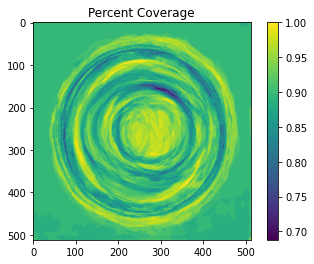

In [15]:
# Predictive Sets

cal_scores_aps = get_calibration_scores_aps(y_cal, cal_probs)
prediction_sets_aps, average_per_pixel_per_image_aps, average_per_image_aps, pct_coverages_aps = cuq_seg_pred_set_aps(cal_scores_aps, test_probs, 0.1, y_test)

print(f'pred set shape: {prediction_sets_aps.shape}, average per pixel per image: {average_per_pixel_per_image_aps.shape}, average per image: {average_per_image_aps.shape}')
print(f'Percent coverage across all pixels {np.round(pct_coverages_aps.mean(), 3)}')
print(f'Mean prediction set size across all pixels and test images: {np.round(average_per_image_aps.mean(), 3)}')

plt.imshow(average_per_pixel_per_image_aps[0])
plt.title('APS')
plt.colorbar()
plt.show()

plt.imshow(100*pct_coverages_aps)
plt.title('Percent Coverage')
plt.colorbar()
plt.show()

Boolean Array: [False False False], Pixel Value: 0
Boolean Array: [False False  True], Pixel Value: 32
Boolean Array: [False  True False], Pixel Value: 64
Boolean Array: [False  True  True], Pixel Value: 96
Boolean Array: [ True False False], Pixel Value: 128
Boolean Array: [ True False  True], Pixel Value: 160
Boolean Array: [ True  True False], Pixel Value: 192
Boolean Array: [ True  True  True], Pixel Value: 224


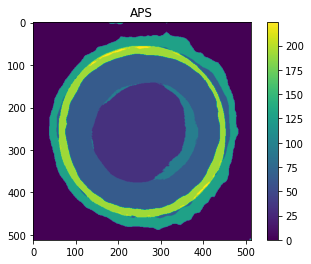

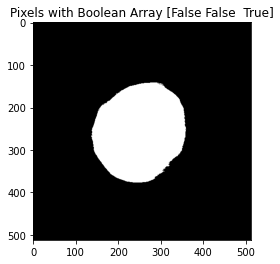

In [16]:
# Plotting

plot_classes(prediction_sets_aps[0], 'APS')

plot_specific_class(prediction_sets_aps[0], np.array([False, False, True]))

### RAPS

Cal scores (307, 1, 512, 512)
pred set shape: (77, 3, 512, 512), average per pixel per image: (77, 512, 512), average per image: (77,)
Percent coverage across all pixels 1.0
Mean prediction set size across all pixels and test images: 0.76


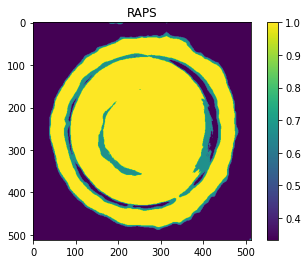

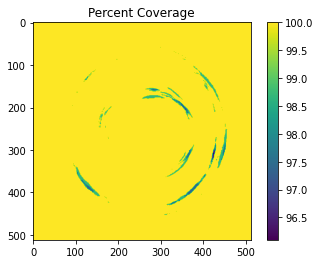

In [17]:
# Predictive Sets

lam_reg = 0.01
disallow_zero_sets = True
randomness = False
cal_scores_raps, reg_vec_tensor = get_calibration_scores_raps(y_cal, cal_probs, lam_reg, qhat_topk)
prediction_sets_raps, average_per_pixel_per_image_raps, average_per_image_raps, pct_coverages_raps = cuq_seg_pred_set_raps(cal_scores_raps, reg_vec_tensor, test_probs, disallow_zero_sets, randomness, 0.1, y_test)

print(f'pred set shape: {prediction_sets_raps.shape}, average per pixel per image: {average_per_pixel_per_image_raps.shape}, average per image: {average_per_image_raps.shape}')
print(f'Percent coverage across all pixels {np.round(pct_coverages_raps.mean(), 3)}')
print(f'Mean prediction set size across all pixels and test images: {np.round(average_per_image_raps.mean(), 3)}')

plt.imshow(average_per_pixel_per_image_raps[0])
plt.title('RAPS')
plt.colorbar()
plt.show()

plt.imshow(100*pct_coverages_raps)
plt.title('Percent Coverage')
plt.colorbar()
plt.show()

Boolean Array: [False False False], Pixel Value: 0
Boolean Array: [False False  True], Pixel Value: 32
Boolean Array: [False  True False], Pixel Value: 64
Boolean Array: [False  True  True], Pixel Value: 96
Boolean Array: [ True False False], Pixel Value: 128
Boolean Array: [ True False  True], Pixel Value: 160
Boolean Array: [ True  True False], Pixel Value: 192
Boolean Array: [ True  True  True], Pixel Value: 224


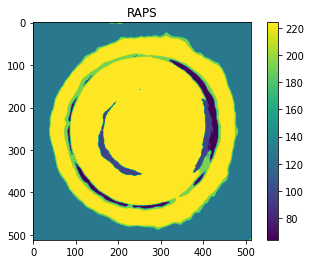

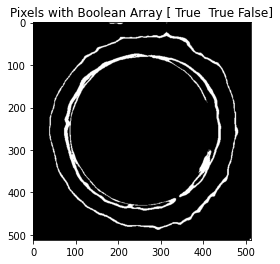

In [18]:
# Plotting

plot_classes(prediction_sets_raps[0], 'RAPS')

plot_specific_class(prediction_sets_raps[0], np.array([True, True, False]))

Note, if we are taking the average of a whole image, the size of the hard portion is going to throw off the calculation. As in, if there are a lot fo background points, the average will be lower, but not better. 

However, for a model with the *same* test sets, $\alpha$ ,etc., lower *will* be better.

We need to do alpha values versus emprical coverage.

# Multiple Plots

Boolean Array: [False False False], Pixel Value: 0
Boolean Array: [False False  True], Pixel Value: 32
Boolean Array: [False  True False], Pixel Value: 64
Boolean Array: [False  True  True], Pixel Value: 96
Boolean Array: [ True False False], Pixel Value: 128
Boolean Array: [ True False  True], Pixel Value: 160
Boolean Array: [ True  True False], Pixel Value: 192
Boolean Array: [ True  True  True], Pixel Value: 224


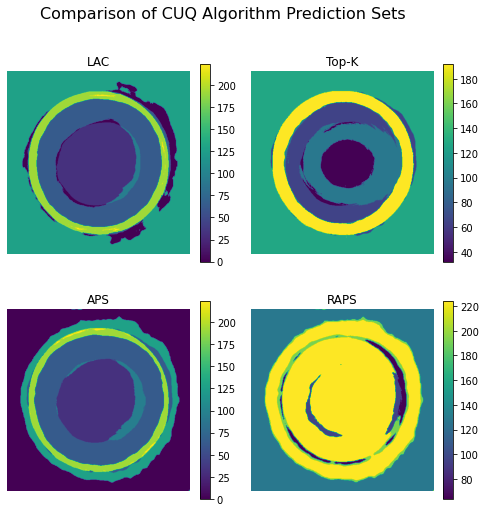

In [19]:
# Multiple Algo Classes

prediction_sets_list = [prediction_sets_lac[0], prediction_sets_topk[0], prediction_sets_aps[0], prediction_sets_raps[0]]
# prediction_sets_list = [prediction_sets_lac[0], prediction_sets_lac[0], prediction_sets_lac[0], prediction_sets_lac[0]]
titles = ['LAC', 'Top-K', 'APS', 'RAPS']
plot_title = 'Comparison of CUQ Algorithm Prediction Sets'

plot_multiple_alg_classes(prediction_sets_list, titles, plot_title)

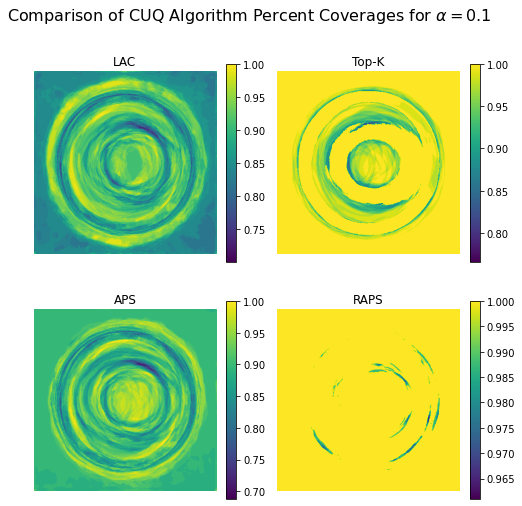

In [20]:
# Multiple Percent Coverages

pct_coverages_list = [pct_coverages_lac, pct_coverages_topk, pct_coverages_aps, pct_coverages_raps]
titles = ['LAC', 'Top-K', 'APS', 'RAPS']
plot_title = r'Comparison of CUQ Algorithm Percent Coverages for $\alpha=0.1$'

plot_multiple_pct_coverages(pct_coverages_list, titles, plot_title)

In [16]:
# RAPS with multiple alphas

lam_reg = 0.01
disallow_zero_sets = True
randomness = False
alphas = [0.2, 0.1, 0.05, 0.01]
pct_coverages_list = []

cal_scores_raps, reg_vec_tensor = get_calibration_scores_raps(y_cal, cal_probs, lam_reg, qhat_topk)
for alpha in alphas:
    _, _, _, pct_coverages_raps_alpha_testing = cuq_seg_pred_set_raps(cal_scores_raps, reg_vec_tensor, test_probs, disallow_zero_sets, randomness, alpha, y_test)
    pct_coverages_list.append(pct_coverages_raps_alpha_testing)



Cal scores (307, 1, 512, 512)
Cal scores (307, 1, 512, 512)
Cal scores (307, 1, 512, 512)
Cal scores (307, 1, 512, 512)


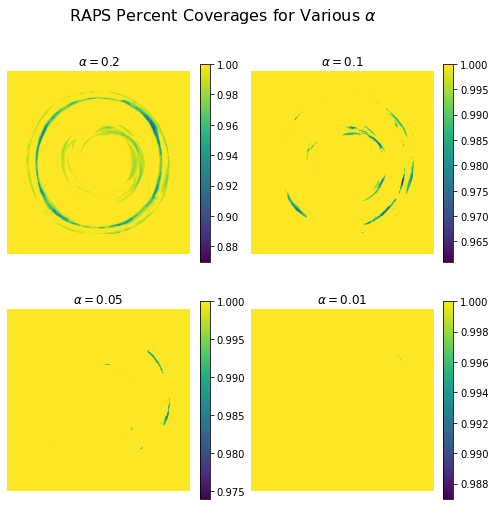

In [17]:

titles = [r'$\alpha=0.2$', r'$\alpha=0.1$', r'$\alpha=0.05$', r'$\alpha=0.01$']
plot_title = r'RAPS Percent Coverages for Various $\alpha$'

plot_multiple_pct_coverages(pct_coverages_list, titles, plot_title)